# 2. Landing page

In [4]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 12, 8
plt.style.use('ggplot')

from catboost import CatBoostClassifier, Pool, cv
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score, confusion_matrix

### Чтение данных

In [3]:
dataset = pd.read_excel('Landing Page Data.xlsx')
dataset.head()

,landing_page,user_id,show_date_time,browser_version,browser,os_name,country
0,lpceuwottvq4,NaN,2015-02-01 00:00:46,39.0.2171.65,Chrome,Windows,CZ
1,lpceuwottvq4,NaN,2015-02-01 00:04:30,NaN,AndroidBrowser,Linux,DE
2,lpceuwottvq4,NaN,2015-02-01 00:08:53,11.0,Microsoft Internet Explorer,Windows,GB
3,lpceuwottvq4,NaN,2015-02-01 00:28:59,40.0.2214.94,Chrome,Windows,PL
4,lpceuwottvq4,NaN,2015-02-01 00:29:11,11.0,Microsoft Internet Explorer,Windows,FR


Преобразуем признак `user_id` в бинарный (`registration`): если в поле `user_id` отсутствует информация, это означает, что пользователь в процессе показа лэндинга не зарегистрировался.

In [5]:
dataset['registration'] = dataset['user_id'].fillna(0).astype('bool').astype('int')
dataset.drop(columns=['user_id'], inplace=True)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15466 entries, 0 to 15465
Data columns (total 7 columns):
landing_page       15466 non-null object
show_date_time     15466 non-null datetime64[ns]
browser_version    14698 non-null object
browser            15314 non-null object
os_name            15188 non-null object
country            15466 non-null object
registration       15466 non-null int64
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 845.9+ KB


### Визуализация

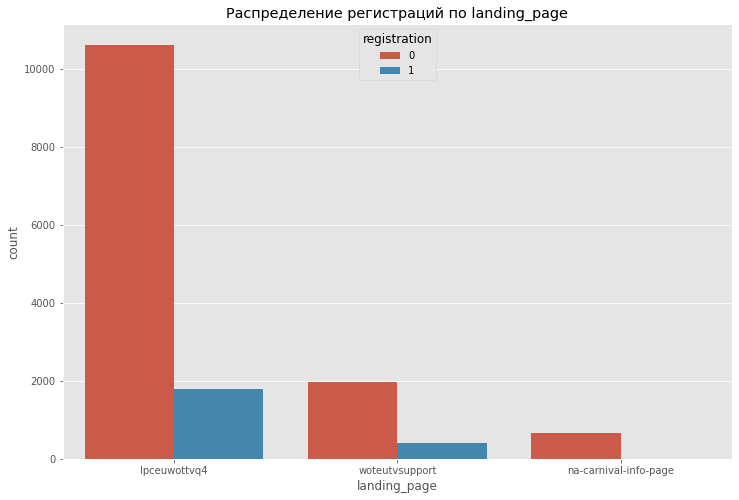

In [7]:
sns.countplot(x=dataset['landing_page'],
              hue=dataset['registration']).set_title('Распределение регистраций по landing_page');

По ссылке `na-carnival-info-page` за данный период времени никто не зарегистрировался

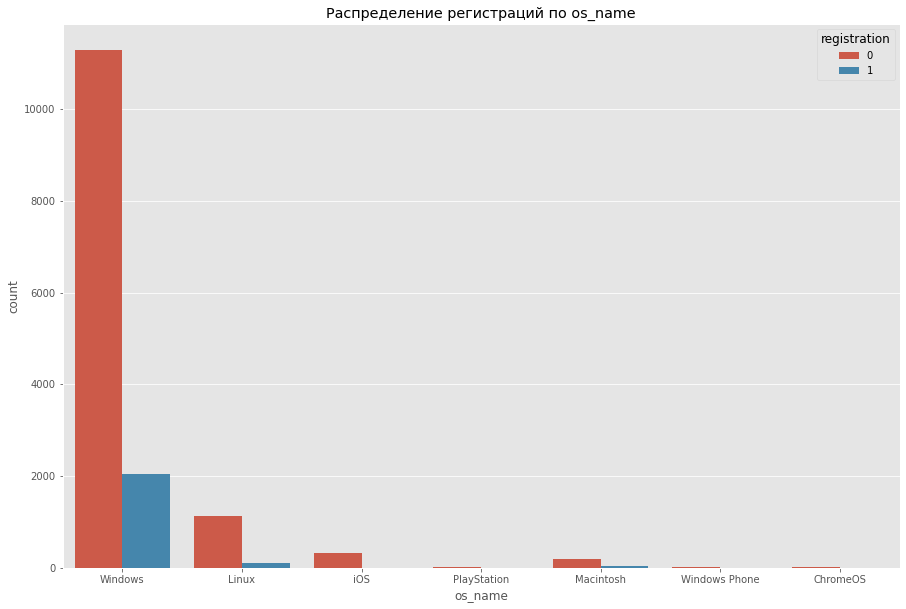

In [8]:
plt.figure(figsize=(15, 10))
sns.countplot(x=dataset['os_name'],
              hue=dataset['registration']).set_title('Распределение регистраций по os_name');

Пользователи, пользующиеся оперционными системами `ChromeOS`, `iOS` зарегистрировались всего 1 раз. С `Windows Phone` не было регистраций. Такой показатель может говорить о том, что данные `landing_page` ведут к регистрации в игре `World of Tanks` (а не к игре `World of Tanks Blitz`), которая не поддерживает мобильные устройства. Низкая регистрация на `ChromeOS` может возникать из-за низкой производительности `ChromeBook` и сложностей с установкой игр.

Основная масса зарегистрировавшихся пользователей пользуется операционными системами `Windows`, `Linux`, `Macintosh`

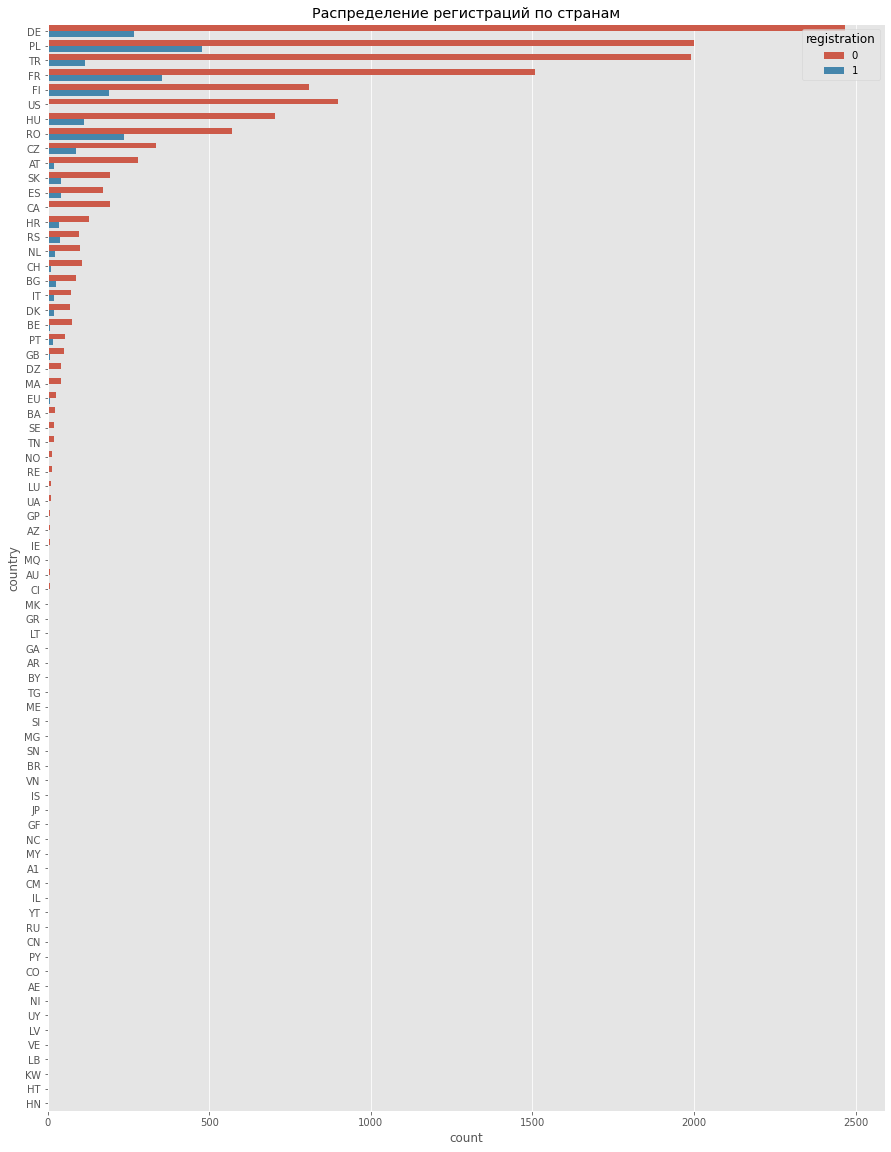

In [9]:
plt.figure(figsize=(15, 20))
sns.countplot(y=dataset['country'],
              hue=dataset['registration'],
              order=dataset['country'].value_counts().index).set_title('Распределение регистраций по странам');

Топ 5 стран по количеству регистраций: `PL`, `FR`, `DE`, `RO`, `FI`

In [10]:
dataset['browser'].unique()

array(['Chrome', 'AndroidBrowser', 'Microsoft Internet Explorer',
       'Firefox', 'GoogleBot', 'Safari', 'Opera', 'ChromeiOS', nan,
       'BingBot', 'Opera Mobile', 'NintendoBrowser', 'SeaMonkey'],
      dtype=object)

In [11]:
dataset['os_name'].unique()

array(['Windows', 'Linux', nan, 'iOS', 'PlayStation', 'Macintosh',
       'Windows Phone', 'ChromeOS'], dtype=object)

1) В данных присутствуют боты для сканирования веб-страниц (GoogleBot и BingBot), у которых не определяется операционная система. Заменим NaN в `os_name` на `Bot_os`.

На платформе PlayStation существует свой браузер, но в данных название браузера отображается, как NaN. Заменим такие значения на `PS_browser`.

В данных остались объекты, операционная система и баузер которых не распознались. Заменим значения NaN в таких объектах, как `unknown`.

2) Временной признак (`show_date_time`) преобразуем в 2 новых (`weekday` и `hour`).

3) Признак `browser_version` не распознается в следующих браузерах: 'AndroidBrowser', 'GoogleBot', 'NintendoBrowser'. Обработаем эти значения, останые заменим на `unknown` версию браузера.

4) Удалим дублирующиеся строчки из данных после всех преобразований

5) В данных есть всего 3 `landing_page`, но по одной из них не было ни одного зарегистрированного пользователя (`na-carnival-info-page`). Удалим ее из данных.

In [12]:
def preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    """
    df - raw dataframe
    """
    new_df = df.copy()
    new_df = new_df.loc[new_df['landing_page'] != 'na-carnival-info-page', :]
    # Generate new features from datetime
    new_df['hour'] = new_df['show_date_time'].apply(lambda x: x.hour)
    new_df['weekday'] = new_df['show_date_time'].apply(lambda x: x.weekday())
    
    # Preprocessing
    new_df.loc[new_df['os_name'] == 'PlayStation', 'browser'] = 'PS_browser'
    new_df.loc[new_df['os_name'] == 'PlayStation', 'browser_version'] = 'PS'
    new_df.loc[new_df['browser'] == 'AndroidBrowser', 'browser_version'] = 'Android'
    new_df.loc[new_df['browser'] == 'GoogleBot', 'browser_version'] = 'Bot'
    
    new_df.loc[(new_df['browser'] == 'GoogleBot') | (new_df['browser'] == 'BingBot'), 'os_name'] = 'Bot_os'
    new_df.fillna('unknown', inplace=True)
    new_df['browser_version'] = new_df['browser_version'].astype('str')
    
    new_df['browser'] = new_df['browser'] + new_df['browser_version']
    new_df.drop(columns=['show_date_time', 'browser_version', #'os_name', 'weekday'#
                        ], inplace=True)
    new_df.drop_duplicates(inplace=True)
    
    
    return new_df

In [13]:
new_df = preprocessing(dataset)
new_df.shape

(9263, 7)

## CatBoost

Построим первую модель. Формализуем задачу, как задачу классификации. В качестве __target__ выступает столбец `registration`, который показывает, зарегистрировался пользовать или нет. `landing_page` используется, как признак. Если вероятность регистрации по ссылке будет маленькой, то изменим `landing_page` на другую. Будем использовать градиентный бустинг. Из-за большого количества категориальных признаков воспользуемся CatBoost. Т.к. данных мало, проверять качество модели будем с помощью кросс-валидации. В качестве метрики качества воспользуемся ROC-AUC.

In [242]:
cat_features = ['landing_page', 'browser', 'os_name', 'country', 'hour', 'weekday']

# tmp = new_df
cv_dataset = Pool(new_df.drop(columns=['registration']), label=new_df['registration'],
                     cat_features=cat_features,
                     feature_names=new_df.drop(columns=['registration']).columns.to_list())

params = {'iterations': 250,
              'learning_rate': 0.03,
              'cat_features': cat_features,
              'loss_function': 'Logloss',
              'eval_metric': 'AUC',
              'verbose': False,
              'od_type': 'IncToDec',
             }

scores = cv(cv_dataset,
            params=params,
            fold_count=3, 
            stratified=True)
scores.tail()

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
245,245,0.777531,0.004694,0.393982,0.005394,0.408908,0.002142
246,246,0.777540,0.004863,0.393970,0.005434,0.408718,0.002033
247,247,0.777557,0.004855,0.393966,0.005435,0.408653,0.002072
248,248,0.777969,0.005634,0.393544,0.006080,0.408369,0.001962
249,249,0.777963,0.005639,0.393548,0.006083,0.408335,0.001927


Такая модель показывает хороший результат по метрике ROC-AUC, однако полнота у такой модели низкая:

* AUC: ~0.78
* Recall: ~0.3
* Precision: ~0.9

Посмотрим на значимость признаков. С помощью нижеописанной функции будем перемешивать значения признаков на объектах и измерять качество с помощью модели.

In [120]:
def shuffle(df: pd.DataFrame, column: str, n: int = 1, axis: int = 0) -> pd.DataFrame:
    df = df.copy()
    feature_val = df[column].to_list()
    for _ in range(n):
        np.random.shuffle(feature_val)
    df[column] = feature_val
    return df

permut_df = shuffle(new_df, 'hour')

In [130]:
cat_features = ['landing_page', 'browser', 'country']

tmp = new_df.drop(columns=['os_name', 'weekday', 'hour']).drop_duplicates()
X_train, X_test, y_train, y_test = train_test_split(tmp.drop(columns=['registration']),
                                                        tmp['registration'], stratify=tmp['registration'],
                                                        train_size=0.7)
    
train_data = Pool(X_train, label=y_train,
                  cat_features=cat_features,
                  feature_names=X_train.columns.to_list())

valid_data = Pool(X_test, label=y_test,
                  cat_features=cat_features,
                  feature_names=X_test.columns.to_list())


params = {'iterations': 250,
              'learning_rate': 0.03,
              'cat_features': cat_features,
              'loss_function': 'Logloss',
              'eval_metric': 'AUC',
              'verbose': False,
              'od_type': 'IncToDec',
             }

cbt_model1 = CatBoostClassifier(**params)
cbt_model1.fit(train_data, eval_set=valid_data, use_best_model=True)
y_pred = cbt_model1.predict(X_test)
print(f'ROC-AUC = {roc_auc_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(tmp.shape)

display(cbt_model1.get_feature_importance(prettified=True))

ROC-AUC = 0.7791615337234369
Recall = 0.5661764705882353
Precision = 0.9625
(1724, 4)


,Feature Id,Importances
0,browser,46.846311
1,country,46.025861
2,landing_page,7.127828


Функция `shuffle` запускалась для каждого признака и был получен следующий результат.
С помощью функции `shuffle` были выделены следующие важные признаки:
* country
* browser

`os_name` при перемешивании значений никак не влиял на качество модели, что говорит о том, что данный признак для данной задачи является шумом. Остальные признаки слабо влияют на качество модели.

Т.к. нам нужно предсказывать вероятность регистрации через `landing page`, построим 2 модели: первая будет предсказывать вероятность регистрации по ссылке __lpceuwottvq4__, вторая по ссылке __woteutvsupport__.

### Модель для lpceuwottvq4

In [235]:
cat_features = ['browser',
                'country',
               ]

land_page1_df = new_df[new_df['landing_page'] == 'lpceuwottvq4']
land_page1_df.drop(columns=['os_name', 'landing_page', 'weekday', 'hour'], inplace=True)
land_page1_df.drop_duplicates(inplace=True)

X_train, X_test, y_train, y_test = train_test_split(land_page1_df.drop(columns=['registration']),
                                                    land_page1_df['registration'],
                                                    stratify=land_page1_df['registration'],
                                                    train_size=0.7)
    
train_data = Pool(X_train, label=y_train,
                  cat_features=cat_features,
                  feature_names=X_train.columns.to_list())

valid_data = Pool(X_test, label=y_test,
                  cat_features=cat_features,
                  feature_names=X_test.columns.to_list())


params = {'iterations': 200,
              'learning_rate': 0.01,
              'cat_features': cat_features,
              'loss_function': 'Logloss',
              'eval_metric': 'AUC',
              'verbose': False,
              'od_type': 'IncToDec',
             }

cbt_model1 = CatBoostClassifier(**params)
cbt_model1.fit(train_data, eval_set=valid_data, use_best_model=True)
y_pred = cbt_model1.predict(X_test)
print(roc_auc_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.7962962962962963
1.0
0.5925925925925926


### Модель для woteutvsupport

In [238]:
cat_features = ['browser',
                'country',
               ]

land_page2_df = new_df[new_df['landing_page'] == 'woteutvsupport']
land_page2_df.drop(columns=['os_name', 'landing_page', 'weekday', 'hour'], inplace=True)
land_page2_df.drop_duplicates(inplace=True)

X_train, X_test, y_train, y_test = train_test_split(land_page2_df.drop(columns=['registration']),
                                                    land_page2_df['registration'],
                                                    stratify=land_page2_df['registration'],
                                                    train_size=0.7)
    
train_data = Pool(X_train, label=y_train,
                  cat_features=cat_features,
                  feature_names=X_train.columns.to_list())

valid_data = Pool(X_test, label=y_test,
                  cat_features=cat_features,
                  feature_names=X_test.columns.to_list())


params = {'iterations': 200,
              'learning_rate': 0.01,
              'cat_features': cat_features,
              'loss_function': 'Logloss',
              'eval_metric': 'AUC',
              'verbose': False,
              'od_type': 'IncToDec',
             }

cbt_model2 = CatBoostClassifier(**params)
cbt_model2.fit(train_data, eval_set=valid_data, use_best_model=True)
y_pred = cbt_model2.predict(X_test)
print(roc_auc_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.7962962962962963
1.0
0.5925925925925926


Проверка моделей на переобученность

In [230]:
cat_features = ['browser', 'country']
scores = []
for landing_page in new_df['landing_page'].unique():
    landing_df = new_df[new_df['landing_page'] == landing_page]
    landing_df.drop(columns=['os_name', 'landing_page', 'weekday', 'hour'], inplace=True)
    landing_df.drop_duplicates(inplace=True)
#     landing_df.drop_duplicates(inplace=True)
    params = {'iterations': 250,
              'learning_rate': 0.01,
              'cat_features': cat_features,
              'loss_function': 'Logloss',
              'eval_metric': 'AUC',
              'verbose': False,
              'od_type': 'IncToDec',
             }
    
    cv_dataset = Pool(landing_df.drop(columns=['registration']), label=landing_df['registration'],
                     cat_features=cat_features,
                     feature_names=landing_df.drop(columns=['registration']).columns.to_list())
    
    scores.append(cv(cv_dataset,
            params=params,
            fold_count=3, 
            stratified=True))
    display(scores[-1].tail())

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
245,245,0.847294,0.042439,0.379326,0.029983,0.406409,0.018538
246,246,0.847286,0.042450,0.379302,0.029990,0.406318,0.018596
247,247,0.847019,0.042342,0.379246,0.030093,0.406167,0.018575
248,248,0.846953,0.042365,0.379242,0.030133,0.405756,0.018571
249,249,0.846795,0.042261,0.379144,0.030275,0.405599,0.018327


,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
245,245,0.779913,0.041232,0.404797,0.016147,0.376566,0.045673
246,246,0.780385,0.042150,0.404790,0.016172,0.376164,0.045922
247,247,0.780866,0.042202,0.404922,0.015890,0.375654,0.046311
248,248,0.780869,0.040993,0.404639,0.015719,0.375379,0.046301
249,249,0.778079,0.041585,0.404588,0.015500,0.375009,0.046313


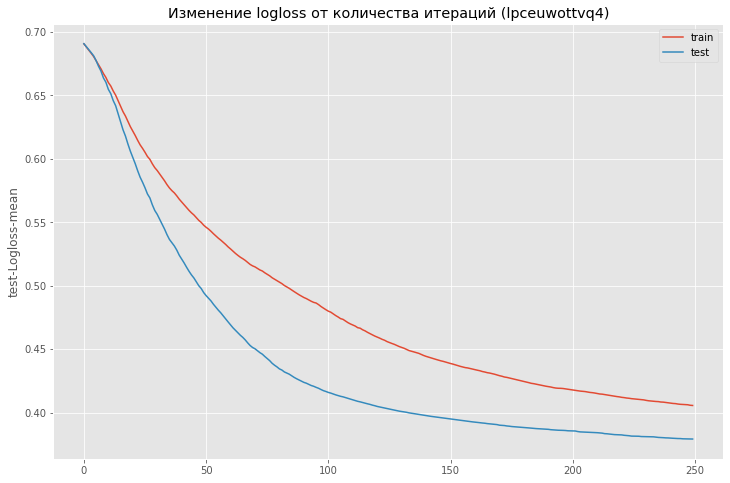

In [231]:
sns.lineplot(x=scores[0].index, y=scores[0]['train-Logloss-mean'], label='train');
sns.lineplot(x=scores[0].index, y=scores[0]['test-Logloss-mean'], label='test').set_title('Изменение logloss от количества итераций (lpceuwottvq4)');

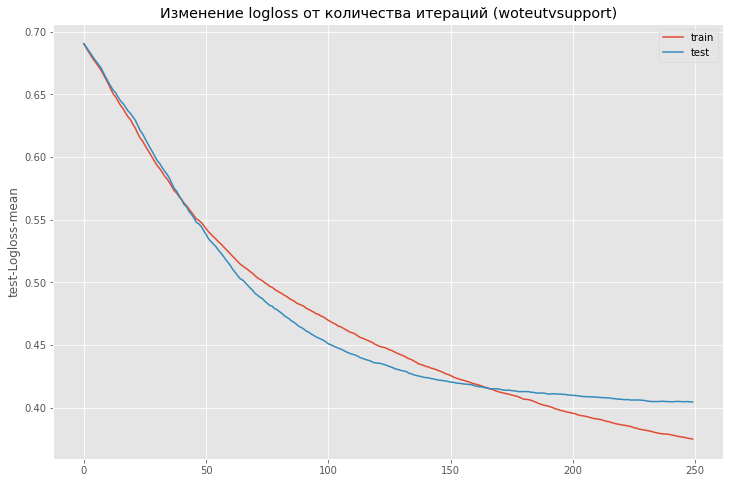

In [232]:
sns.lineplot(x=scores[1].index, y=scores[1]['train-Logloss-mean'], label='train');
sns.lineplot(x=scores[1].index, y=scores[1]['test-Logloss-mean'], label='test').set_title('Изменение logloss от количества итераций (woteutvsupport)');

Идея была следущая:
имеем две модели, которые могут могут предсказывать вероятность регистрации через соответствующую ссылку. Подавая на вход этим моделям новые данные, мы будем знать вероятность регистрации через каждую ссылку. Если вероятность для одной из ссылок высокая, то показываем ее пользователю. Если вероятность для обоих ссылок плохая, то показываем третью (`na-carnival-info-page`).
Но т.к. Recall обоих моделей имеет низкое среднее значение и большое отклонение, то в случае с низкой вероятностью регистрации пользователя имеет смысл показывать любую из трёх ссылок.


Прототип функции, предсказывающей вероятность регистрации

In [241]:
def predict(df: pd.DataFrame) -> pd.DataFrame:
    
    # preprocessing
    df.loc[new_df['browser'] == 'AndroidBrowser', 'browser_version'] = 'Android'
    df.loc[new_df['browser'] == 'GoogleBot', 'browser_version'] = 'Bot'
    df.loc[(new_df['browser'] == 'GoogleBot') | (df['browser'] == 'BingBot'), 'os_name'] = 'Bot_os'
    df.fillna('unknown', inplace=True)
    df['browser_version'] = df['browser_version'].astype('str')
    
    df.drop(columns=['show_date_time', 'browser_version', 'os_name', 'landing_page'],
            inplace=True)
    
    # prediction
    y_pred1 = ctb_model1.predict_broba(df)[:, 1]
    y_pred2 = ctb_model2.predict_broba(df)[:, 1]
    return pd.DataFrame(data={'lpceuwottvq4': y_pred1, 'woteutvsupport': y_pred2})

С другой стороны, отбросив нерепрезентативные признаки, а затем убрав дубликаты из dataset'а, осталось слишком маленькое количество данных. К тому же стандартное отклонение метрик качества имеет высокие значения (~0.05), что делает модель неустойчивой.

Т.к. модель неусточивая, то пользоваться ей не стоит. Что может улучшить качество и сделать модель стабильнее: 1) больший объем данных, 2) новые репрезентативные признаки (например, описание самого лендинга), 3) новая модель.